# Решающие деревья. Домашнее задание

Данные, с которыми мы сегодня работаем взяты из учебного соревнования на платформе Kaggle: https://www.kaggle.com/c/titanic/data?select=test.csv

**Задача**: по разным характеристикам пассажиров лайнера предсказать выживет ли конкретный пассажир или нет

**Тип**: бинарная классификация

## Подготовка данных

Загрузим и посмотрим на данные

In [1]:
import pandas as pd

path = './data/titanic.csv'
data = pd.read_csv(path)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Заведем 2 списка: в один будем записывать категориальные признаки, в другой - числовые

In [3]:
categorical_features = []
numerical_features = []

Посмотрим на пропуски в данных

In [4]:
data.isna().mean(axis=0)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

Добавим Pclass в числовые признаки

In [5]:
numerical_features.append('Pclass')

Посмотрим на признак Sex

In [6]:
data['Sex'].value_counts(dropna=False)

male      577
female    314
Name: Sex, dtype: int64

In [7]:
categorical_features.append('Sex')

Обработаем признак возраста - Age

In [8]:
data['Age'] = data['Age'].fillna(data['Age'].mean())

In [9]:
numerical_features.append('Age')

Добавим признаки SibSp, Parch, Fare в список числовых признаков

In [10]:
numerical_features.extend(['SibSp', 'Parch', 'Fare'])

Посмотрим на признак Embarked

In [11]:
embarked_stat = data['Embarked'].value_counts(dropna=False)
embarked_stat

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [12]:
categorical_features.append('Embarked')

Посчитаем итоговое суммарное количество уникальных значение закодированных категориальных признаков

In [14]:
number_of_categorical = sum([data[field].nunique(dropna=False) for field in categorical_features])
number_of_categorical

6

Завершим предобработку категориальных признаков тем, что закодируем их с помощью one-hot-encoding

In [15]:
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder()
encoder.fit(data[categorical_features])
categories = []
for i, feature in enumerate(categorical_features):
    categories.extend([f'{feature}: {value}' for value in encoder.categories_[i]])
data.loc[:, categories] = encoder.transform(data[categorical_features]).toarray().astype(int)

/var/folders/wb/r313lqxj0blcb_3d4p6nv5zw0000gn/T/ipykernel_1066/3654389271.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, categories] = encoder.transform(data[categorical_features]).toarray().astype(int)


## Обучение модели


Для начала, разделим данные на обучающую и тестовую выборки

In [16]:
from sklearn.model_selection import train_test_split


features = numerical_features + categories
X = data[features]
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Посмотрим как стратификация повлияла на распределения целевых признаков в обучающей и тестовой выборках

In [17]:
np.round(y_train.value_counts() / y_train.shape[0] * 100, 2)

0    61.64
1    38.36
Name: Survived, dtype: float64

In [18]:
np.round(y_test.value_counts() / y_test.shape[0] * 100, 2)

0    61.57
1    38.43
Name: Survived, dtype: float64

Инициализируем и обучим модель

In [19]:
from sklearn.tree import DecisionTreeClassifier


tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

Для удобства создаем функцию, которая будет возвращать метрики сразу на обучающих и тестовых данных:

In [20]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


def get_metrics(model):
    results = []
    y_pred = model.predict_proba(X_train)
    roc_auc = roc_auc_score(y_train, y_pred[:, 1])
    acc = accuracy_score(y_train, y_pred.argmax(axis=1))
    f1 = f1_score(y_train, y_pred.argmax(axis=1))
    results.append(['Train', roc_auc, acc, f1])
    y_pred = model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_pred[:, 1])
    acc = accuracy_score(y_test, y_pred.argmax(axis=1))
    f1 = f1_score(y_test, y_pred.argmax(axis=1))
    results.append(['Test', roc_auc, acc, f1])
    return pd.DataFrame(columns=['Group', 'ROC-AUC', 'Accuracy', 'F1'], data=results)

In [21]:
get_metrics(tree)

,Group,ROC-AUC,Accuracy,F1
0,Train,0.999090,0.980738,0.974359
1,Test,0.739659,0.757463,0.679803


Сделаем подбор гиперпараметров с помощью поиска по сетке:

In [22]:
from sklearn.model_selection import GridSearchCV


grid = {'max_depth': [1, 2, 3, 5, 10, None],
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [1, 5, 10, 50],
        'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1]}
search = GridSearchCV(tree, grid)
search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 5, 10, None],
                         'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
                         'min_samples_leaf': [1, 5, 10, 50]})

Проверим какое качество показывает модель на подобранных параметрах

In [23]:
tree = DecisionTreeClassifier(**search.best_params_,)
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [24]:
get_metrics(tree)

,Group,ROC-AUC,Accuracy,F1
0,Train,0.897964,0.858748,0.794393
1,Test,0.838247,0.791045,0.685393


## Бонусы деревьев решений

Посмотрим на важность признаков

In [25]:
pd.DataFrame(data={'feature': features, 
                   'importance': tree.feature_importances_}).sort_values('importance', ascending=False).iloc[:10]

,feature,importance
6,Sex: male,0.482890
0,Pclass,0.190310
1,Age,0.142735
4,Fare,0.141649
2,SibSp,0.033487
3,Parch,0.008929
5,Sex: female,0.000000
7,Embarked: C,0.000000
8,Embarked: Q,0.000000
9,Embarked: S,0.000000


Попробуем визуализировать дерево

[Text(0.5, 0.8333333333333334, 'Sex: female <= 0.5\ngini = 0.473\nsamples = 100.0%\nvalue = [0.616, 0.384]'),
 Text(0.25, 0.5, 'Age <= 3.5\ngini = 0.304\nsamples = 65.2%\nvalue = [0.813, 0.187]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.153\nsamples = 1.9%\nvalue = [0.083, 0.917]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.276\nsamples = 63.2%\nvalue = [0.835, 0.165]'),
 Text(0.75, 0.5, 'Pclass <= 2.5\ngini = 0.374\nsamples = 34.8%\nvalue = [0.249, 0.751]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.112\nsamples = 18.8%\nvalue = [0.06, 0.94]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.498\nsamples = 16.1%\nvalue = [0.47, 0.53]')]

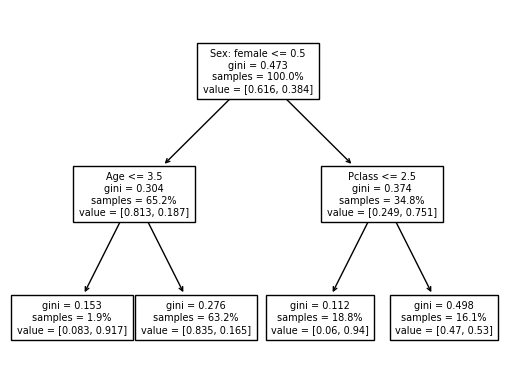

In [26]:
from sklearn.tree import plot_tree


tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train, y_train)
plot_tree(tree, feature_names=features, fontsize=7, proportion=True)

In [33]:
obj = {'Pclass': 1,
 'Age': 33,
 'SibSp': 0,
 'Parch': 2,
 'Fare': 70,
 'Sex: female': 1,
 'Sex: male': 0,
 'Embarked: C': 0,
 'Embarked: Q': 0,
 'Embarked: S': 1,
 'Embarked: nan': 0}

In [34]:
obj = pd.DataFrame(obj, index=[0])

In [32]:
tree.predict_proba(obj)

array([[0.83502538, 0.16497462]])

In [35]:
tree.predict_proba(obj)

array([[0.05982906, 0.94017094]])